Index(['geometry'], dtype='object')
Number of DSM data points: 10083800
Number of LAS data points: 9236517


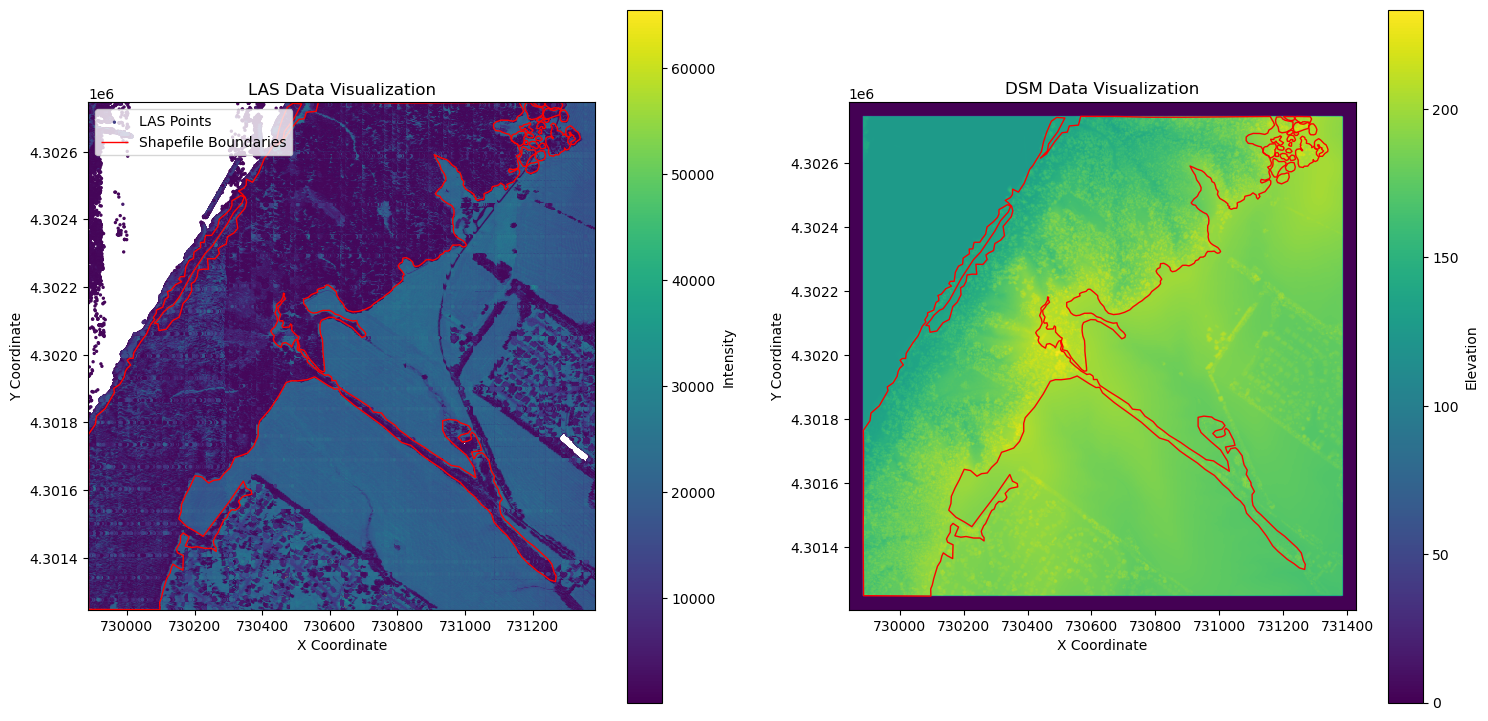

In [1]:
import laspy
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

las_out_filename = 'SaintLouisLiDAR.las'

# Read LAS file
las_file = laspy.read(las_out_filename)

# Selected fields from the LAS file
selected_fields = ['intensity', 'return_number', 'number_of_returns', 'red', 'green', 'blue', 'nir']

# Read shapefile for labels
shapefile_name = 'SaintLouisTrees'
shp_filename = f'{shapefile_name}.shp'
gdf = gpd.read_file(shp_filename)

# Set CRS for GeoDataFrame
gdf = gdf.set_crs(epsg=4326)

print(gdf.columns)

# Read DSM file separately to avoid closure issues
dsm_filename = 'SaintLouisDSM.tif'
with rasterio.open(dsm_filename) as dsm_dataset:
    dsm = dsm_dataset.read(1)

    # Extract features from LAS file
    las_points = np.vstack((las_file.x, las_file.y, las_file.z, las_file.intensity,
                            las_file.return_number, las_file.number_of_returns,
                            las_file.red, las_file.green, las_file.blue, las_file.nir)).T

    # Create a DataFrame for the LAS features
    las_df = pd.DataFrame(las_points, columns=['x', 'y', 'z', 'intensity', 'return_number',
                                               'number_of_returns', 'red', 'green', 'blue', 'nir'])

    # Add elevation from DSM to las_df
    las_df['elevation'] = [x[0] for x in dsm_dataset.sample([(x, y) for x, y in zip(las_df['x'], las_df['y'])])]

# Check LAS CRS
las_crs = las_file.header.parse_crs()

# Set epsg
gdf = gdf.to_crs(epsg=4326)

print("Number of DSM data points:", dsm.shape[0] * dsm.shape[1])
print("Number of LAS data points:", las_points.shape[0])

# Plot LAS points, shapefile boundaries, and DSM
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# Plot LAS points and shapefile boundaries for LAS data
ax1.set_xlim(las_df['x'].min(), las_df['x'].max())
ax1.set_ylim(las_df['y'].min(), las_df['y'].max())
scatter = ax1.scatter(las_df['x'], las_df['y'], c=las_df['intensity'], cmap='viridis', s=2, label='LAS Points')
gdf.boundary.plot(ax=ax1, color='red', linewidth=1, label='Shapefile Boundaries')
ax1.set_title('LAS Data Visualization')
ax1.set_xlabel('X Coordinate')
ax1.set_ylabel('Y Coordinate')
fig.colorbar(scatter, ax=ax1, label='Intensity')
ax1.legend(loc="upper left")

# Plot DSM data
cax2 = ax2.imshow(dsm, cmap='viridis', extent=[dsm_dataset.bounds.left, dsm_dataset.bounds.right,
                                                dsm_dataset.bounds.bottom, dsm_dataset.bounds.top])
ax2.set_title('DSM Data Visualization')
ax2.set_xlabel('X Coordinate')
ax2.set_ylabel('Y Coordinate')
fig.colorbar(cax2, ax=ax2, label='Elevation')

# Overlay shapefile boundaries on DSM data
gdf.boundary.plot(ax=ax2, color='red', linewidth=1, label='Shapefile Boundaries')

# Set the aspect ratio to be equal in both subplots
ax1.set_aspect('equal')
ax2.set_aspect('equal')

# Show the plots
plt.show()

In [2]:
# Create a new column in the GeoDataFrame to store tree presence labels
# Merge LAS data with the GeoDataFrame based on the spatial coordinates
las_gdf = gpd.GeoDataFrame(las_df, geometry=gpd.points_from_xy(las_df['x'], las_df['y']), crs=las_crs)
merged_gdf = gpd.sjoin(las_gdf, gdf, how="left", op="intersects")
gdf['tree_presence'] = 0

print("1")

# Define a buffer around tree points
buffer_distance = 10.0
merged_gdf['tree_presence'] = 0

print("2")

# Assuming 'geometry' is the column containing Point geometries in merged_gdf
merged_gdf['geometry'] = [Point(x, y) for x, y in zip(merged_gdf['x'], merged_gdf['y'])]

# Create a GeoDataFrame from merged_gdf
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')

# Create a spatial index for gdf
gdf_sindex = gdf.sindex

# Create a buffer around the LAS points
point_buffers = merged_gdf['geometry'].buffer(buffer_distance)

# Check if the LAS point buffer intersects with any tree in a vectorized manner
intersects = gdf_sindex.query_bulk(point_buffers, predicate='intersects')

# Set 'tree_presence' to 1 for LAS points within tree buffers
merged_gdf['tree_presence'] = 0
# Use np.hstack to flatten the list of tuples
merged_gdf.loc[np.hstack(intersects), 'tree_presence'] = 1

# Add "elevation" field to selected fields
selected_fields.append('elevation')

# Prepare features and labels for model training
X = merged_gdf[selected_fields].values
y = merged_gdf['tree_presence'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Drop rows with NaN values in the target variable
nan_rows = np.isnan(y_train)
X_train_scaled = X_train_scaled[~nan_rows]
y_train = y_train[~nan_rows]

# Verify that there are no NaN values in X_train_scaled
nan_in_X_train_scaled = np.isnan(X_train_scaled)
if np.any(nan_in_X_train_scaled):
    raise ValueError("NaN values found in X_train_scaled after dropping NaN values from y_train.")

C:\Users\User\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\User\AppData\Local\Temp\ipykernel_2532\1294129371.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: COMPD_CS["NAD83(2011) / UTM zone 15N + NAVD88 heig ...
Right CRS: EPSG:4326

  merged_gdf = gpd.sjoin(las_gdf, gdf, how="left", op="intersects")


1
2


C:\Users\User\AppData\Local\Temp\ipykernel_2532\1294129371.py:28: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  intersects = gdf_sindex.query_bulk(point_buffers, predicate='intersects')


C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Accuracy on the test set: 0.91061743739204


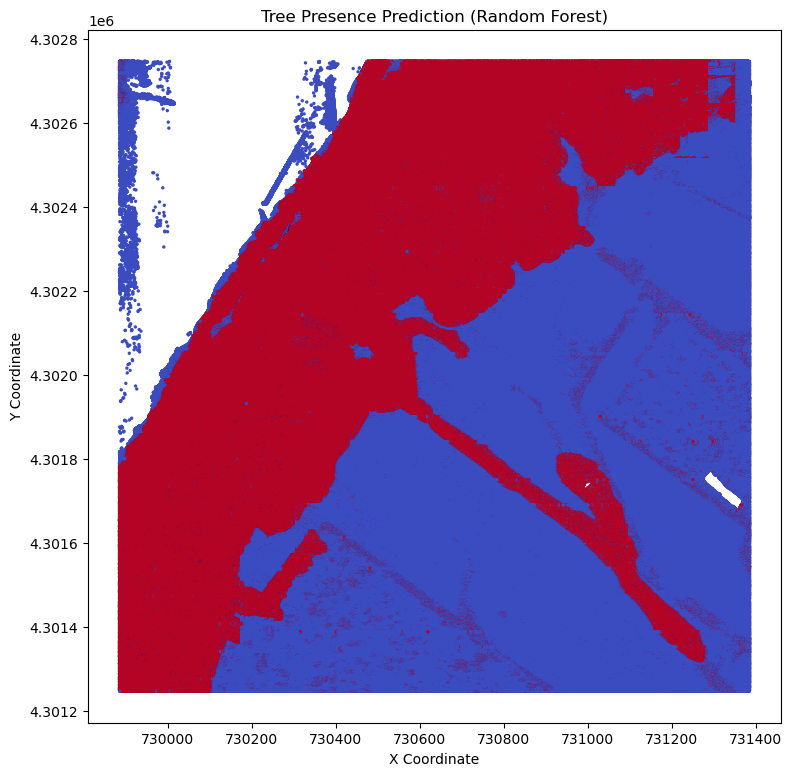

In [3]:
# Train Random Forest model
model = RandomForestClassifier(n_estimators=30, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict tree presence on the entire LAS dataset
merged_gdf['tree_presence_pred'] = model.predict(scaler.transform(merged_gdf[selected_fields]))

# Evaluate accuracy on the test set
y_test_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on the test set: {accuracy}")

# Plot tree presence predicted by the model
fig, ax3 = plt.subplots(figsize=(9, 9))
scatter_tree_pred = ax3.scatter(merged_gdf['x'], merged_gdf['y'], c=merged_gdf['tree_presence_pred'], cmap='coolwarm', s=2)
ax3.set_title('Tree Presence Prediction (Random Forest)')
ax3.set_xlabel('X Coordinate')
ax3.set_ylabel('Y Coordinate')
ax3.set_aspect('equal')
plt.show()